The goal of this notebook is to develop a reworked single cell RNA-seq simulation strategy. As an overall outline for this strategy, we want to:
1. Simulate a count-based expression matrix for an individual
2. Run simulations for a specified number cases and controls
3. Combine the data across individuals and cluster 
4. test for differential abundance with MASC.

The part of the simulation strategy being developd here corresponds to step 1 above. The plan relies using centroids to define populations in low-dimensional space, adjusting the "position" of those centroids to account for batch and inter-individual differences, generating low dimensional representations of single cells using the population centroids for each population according to pre-defined frequencies; projecting the cells into high dimensions using gaussians (i.e., cells x low-dimensional -> cells x genes); returning the simulated count matrix with an associated meta_data table.

Overall flow of the simulation function should look like this:
inputs: 
- 2-dimensional centroids for each cluster
- variance in centroid location in each dimension for each cluster 
- number of genes simulated
- number of cells per donor
- number of cases
- number of controls
- number of batches
- cluster frequency among cases
- cluster frequency among controls

outputs:
- expression matrix containing all cells (across donors) x genes
- metadata table linking each cell to the donor/batch/case-control status
- simulation settings readout that reports the initial simulation parameters AND the low-dimensional shifts applied to each donor and each batch

# Load libraries

In [322]:
source("/PHShome/cyf0/Projects/scpower/R/libs.R")
source("/PHShome/cyf0/Projects/scpower/R/utils.R")

In [353]:
suppressMessages(source("/PHShome/cyf0/Projects/power/src/graphFn.R"))

# Simulation functions

In [18]:
distributeSamples <- function(ncases, nctrls, nbatches) {
    # Return a list, where batch has a 2-length vector naming the cases and controls for that batch
    batches <- vector(mode = "list", length = nbatches)
    names(batches) <- paste0("batch", 1:nbatches)
    stopifnot(nbatches < ncases)
    stopifnot(nbatches < nctrls)
    
    # Create donor names and distribute to cases and controls
    donor_names <- paste0("donor", 1:sum(ncases, nctrls))
    case_idx <- sample(length(donor_names), ncases)
    case_names <- donor_names[case_idx]
    ctrl_names <- donor_names[-case_idx]
    
    # Check if total number of cases can fit evenly into the number of batches
    case_remainder <- ncases %% nbatches
    case_per_batch <- floor(ncases/nbatches)
    if (case_remainder != 0) {
        message(paste0("WARNING: ", ncases, " case samples cannot be evenly distributed into ", nbatches, " batches, putting remainder in last batch..."))
    } 
    
    # Assign cases to each batch, except for final batch
    for (i in 1:(nbatches - 1)) {
            case_select <- sample(length(case_names), case_per_batch)
            batches[[i]]$cases <- case_names[case_select]
            case_names <- case_names[-case_select]
    }
    # Assign remaining case names to final batch
    batches[[nbatches]]$cases <- case_names

    # Check if total number of controls can fit evenly into the number of batches
    ctrl_remainder <- nctrls %% nbatches
    ctrl_per_batch <- floor(nctrls/nbatches)
    if (ctrl_remainder != 0) {
        message(paste0("WARNING: ", nctrls, " control samples cannot be evenly distributed into ", nbatches, " batches, putting remainder in last batch..."))
    } 
    
    # Assign cases to each batch, except for final batch
    for (i in 1:(nbatches - 1)) {
            ctrl_select <- sample(length(ctrl_names), ctrl_per_batch)
            batches[[i]]$ctrls <- ctrl_names[ctrl_select]
            ctrl_names <- ctrl_names[-ctrl_select]
    }
    # Assign remaining control names to final batch
    batches[[nbatches]]$ctrls <- ctrl_names

    return(list(batches = batches,
                donor_names = donor_names))
}

In [71]:
generateShifts <- function(batch_list, nclusters, batch_sd) {
    batch_shifts <- lapply(1:length(batch_list), function(x) {
        # Generate low-dimensional batch effects from multivariate normal with no covariance between dimensions
        shift <- mvrnorm(nclusters, mu = c(0, 0), Sigma = diag(c(batch_sd, batch_sd)))
        data.frame(D1 = shift[ ,1], D2 = shift[ ,2])
    })
    names(batch_shifts) <- names(batch_list)
    return(batch_shifts)
}

In [205]:
simulateDonor <- function(centroid_list, centroid_variance, ngenes, ncells, cluster_frequency, batch_shift, donor_sd, projection) {
    nclusters <- nrow(centroid_list)
    # Assign cells to clusters
    cell_cluster_assignments <- sample(1:nclusters, prob = cluster_frequency, size = ncells, replace = TRUE)
    # Generate donor shifts
    donor_shift <- mvrnorm(nclusters, mu = c(0, 0), Sigma = diag(c(donor_sd, donor_sd)))
    # Adjust cluster centroids for batch and donor noise
    adj_centroid <- centroid_list + donor_shift + batch_shift
    # Place cells in low-dimensional space, using adjusted cluster centroids and centroid variance for each dim independently
    cells_lowD <- cbind(rnorm(n = ncells, 
                              mean = adj_centroid[cell_cluster_assignments, 1], 
                              sd = centroid_variance[cell_cluster_assignments, 1]),
                        rnorm(n = ncells, 
                              mean = adj_centroid[cell_cluster_assignments, 2], 
                              sd = centroid_variance[cell_cluster_assignments, 2]))
    # Multiply low-dim cell matrix (cells x lowD) by random gaussian projection matrix transposed (lowD x genes) to get cell x gene expression matrix
    exprs <- cells_lowD %*% t(projection)
    return(list(exprs = exprs,
                cluster_assign = cell_cluster_assignments))
}

## Fullly simulating a dataset

This function will have the following inputs:
- 2-dimensional centroids for each cluster
- variance in centroid location in each dimension for each cluster
- number of genes simulated
- number of cells per donor
- cluster frequencies
- batch-specific shift
- donor-specific shift

The function should return a cells x genes matrix AND a metadata table with cell rows and the following columns
- Simulated celltype
- donor name (i.e., donor1, donor2)
- donor status (i.e., case or control)
- batch name (i.e., batch1, batch2)

In [306]:
simulateDataset <- function(centroid_list, centroid_variance, ngenes, ncells, nbatches, ncases, nctrls,
                            case_cluster_frequency, ctrl_cluster_frequency, batch_sd, donor_sd) {
    # set.seed(seed)
    proj <- matrix(rnorm(ngenes*ncells), nrow=ngenes, ncol=2)
    nclusters <- nrow(centroid_list)
    celltypes <- paste("cluster", 1:nclusters, sep = "_")
    
    # Distribute samples into batches
    sampleDist <- distributeSamples(nbatches = nbatches, ncases = ncases, nctrls = nctrls)
    
    # Generate batch effects
    batch_shifts <- generateShifts(batch_list = sampleDist$batches, nclusters = nclusters, batch_sd = batch_sd)
    
    # Set up lists to store output data
    exprs.batches <- vector(mode = "list", length = length(sampleDist$batches))
    names(exprs.batches) <- names(sampleDist$batches)
    
    meta.batches <- vector(mode = "list", length = length(sampleDist$batches))
    names(meta.batches) <- names(sampleDist$batches)

    # Simulate donors by batch
    for (k in 1:length(sampleDist$batches)) {
        batch <- names(sampleDist$batches)[k]
        # Simulate cases
        cases <- sampleDist$batches[[batch]]$cases
        sim.cases <- lapply(cases, function(x) {
            simulateDonor(centroid_list, centroid_variance, ngenes, ncells, case_cluster_frequency, batch_shifts[[batch]], donor_sd, projection = proj)
        })
        exprs.cases <- do.call('rbind', lapply(sim.cases, "[[", 1))
        celltype.cases <- do.call('c', lapply(sim.cases, "[[", 2))
        
        # Simulate controls
        ctrls <- sampleDist$batches[[batch]]$ctrls
        sim.ctrls <- lapply(ctrls, function(x) {
            simulateDonor(centroid_list, centroid_variance, ngenes, ncells, ctrl_cluster_frequency, batch_shifts[[batch]], donor_sd, projection = proj)
        })
        exprs.ctrls <- do.call('rbind', lapply(sim.ctrls, "[[", 1))
        celltype.ctrls <- do.call('c', lapply(sim.ctrls, "[[", 2))

        # Bind cases and controls together within batch and create metadata table
        exprs.batch <- rbind(exprs.cases, exprs.ctrls)
        meta.batch <- data.frame(celltype = c(celltype.cases, celltype.ctrls),
                                 donor = c(rep(cases, each = ncells), rep(ctrls, each = ncells)),
                                 status = rep(c("case", "ctrl"), times = c((length(cases) * ncells), (length(ctrls) * ncells))))
        meta.batch$batch <- rep(batch, nrow(meta.batch))
        
        # Save to lists
        exprs.batches[[k]] <- exprs.batch
        meta.batches[[k]] <- meta.batch
        
        message(paste0("Simulated ", length(cases), " cases and ", length(ctrls), " controls in batch ", k))

    }
    
    # Combine data across batches and run PCA
    exprs <- do.call('rbind', exprs.batches)
    meta <- do.call('rbind', meta.batches)
    
    message(paste0("Finished simulating a ", nrow(exprs), " cell by ", ncol(exprs), " gene dataset consisting of ", length(unique(meta[meta$status == "case",]$donor)),
                   " cases and ", length(unique(meta[meta$status == "ctrl",]$donor)), " controls"))

    return(list(exprs = exprs, meta = meta))

}


# Scratch development

Let's create a couple cluster centroids in low-dimensional space

In [74]:
scratch_clusters <- rbind(data.frame(mvrnorm(n = 100, mu = c(2, 2), Sigma = matrix(c(1, 0, 0, 1), 2, 2))),
                          data.frame(mvrnorm(n = 100, mu = c(0, 0), Sigma = matrix(c(1, 0, 0, 1), 2, 2))),
                          data.frame(mvrnorm(n = 100, mu = c(-2, -2), Sigma = matrix(c(1, 0, 0, 1), 2, 2))))
scratch_clusters$cluster <- as.character(rep(1:3, each = 100))
colnames(scratch_clusters) <- c("X", "Y", "cluster")
scratch_clusters  %>% head

X         Y         cluster
1 3.1001882 5.0580659 1      
2 2.9680917 2.1634273 1      
3 1.6828619 2.6506431 1      
4 0.8595873 0.9705874 1      
5 3.8690286 2.1205758 1      
6 3.6070880 1.1876910 1

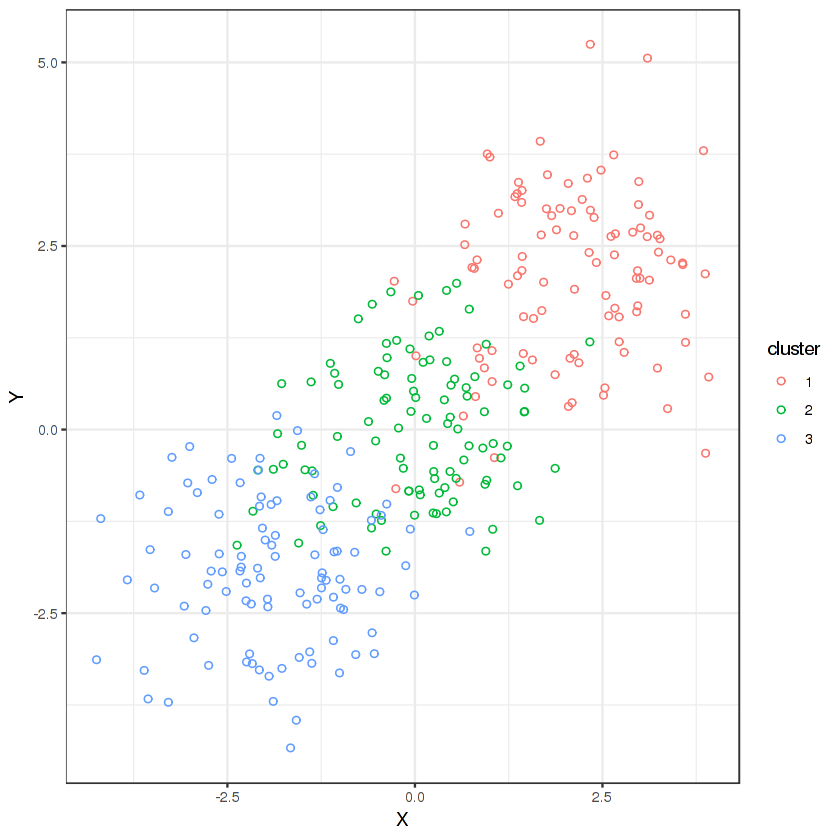

In [75]:
scratch_clusters %>%
    ggplot(aes(x = X, y = Y)) +
    geom_point(shape = 21, aes(color = cluster)) +
    theme_bw()

Let's calculate a 2-dimensional centroid for each cluster, as well as the cluster-specific variance in each dimension

In [149]:
centroid_list <- scratch_clusters %>% 
    group_by(cluster) %>%
    summarise(D1.mean = mean(X),
              D2.mean = mean(Y)) %>%
    dplyr::select(-cluster)
centroid_list
centroid_variance <- scratch_clusters %>% 
    group_by(cluster) %>%
    summarise(D1.sd = sd(X),
              D2.sd = sd(Y)) %>%
    dplyr::select(-cluster) %>% as.data.frame
centroid_variance

D1.mean      D2.mean     
1  2.083833215  2.067920775
2 -0.002293828 -0.006841137
3 -1.880876159 -1.932569194

D1.sd     D2.sd    
1 1.0003371 1.1668578
2 0.9671319 0.9295586
3 0.9846412 0.9685099

Now let's set the parameters for the simulation

## Batch and Donor at 10% of centroid variance

In [293]:
ncells <- 1000
ngenes <- 500
nbatches <- 4
ncases <- 12
nctrls <- 12
case_freq <- c(0.2, 0.3, 0.5)
ctrl_freq <- rep(1/3, 3)
batch_sd <- 0.1
donor_sd <- 0.1

In [307]:
testSim <- simulateDataset(centroid_list = centroid_list, 
                            centroid_variance = centroid_variance, 
                            ngenes = ngenes,
                            ncells = ncells, 
                            nbatches = nbatches, 
                            ncases = ncases, 
                            nctrls = nctrls,
                            case_cluster_frequency = case_freq,
                            ctrl_cluster_frequency = ctrl_freq, 
                            batch_sd = batch_sd, 
                            donor_sd = donor_sd) 

Simulated 3 cases and 3 controls in batch 1
Simulated 3 cases and 3 controls in batch 2
Simulated 3 cases and 3 controls in batch 3
Simulated 3 cases and 3 controls in batch 4
Finished simulating a 24000 cell by 500 gene dataset consisting of 12 cases and 12 controls


In [310]:
sim.counts <- testSim$meta %>% 
    mutate(celltype.f = factor(celltype)) %>% 
    dplyr::group_by(status, donor, celltype.f) %>% 
    summarise(ncells = n()) %>% 
    complete(celltype.f, fill = list(ncells = 0)) %>%
    ungroup() %>%
    group_by(donor) %>%
    mutate(freq = ncells/sum(ncells))
head(sim.counts)

status donor   celltype.f ncells freq 
1 case   donor10 1          196    0.196
2 case   donor10 2          283    0.283
3 case   donor10 3          521    0.521
4 case   donor5  1          209    0.209
5 case   donor5  2          305    0.305
6 case   donor5  3          486    0.486

In [ ]:
sim.counts %>% 
    ggplot(aes(x = celltype.f, y = freq)) +
    geom_boxplot(aes(color = status)) +
    geom_point(aes(group = status, color = status), position = position_dodge(width = 0.75)) +
    theme_bw() +
    GenericTheme +
    scale_color_fivethirtyeight()

Run PCA and UMAP, apply modularity clustering, and visualize

In [336]:
str(testSim)

List of 3
 $ exprs: num [1:24000, 1:500] 0.0737 -2.1969 -1.8754 1.0525 2.0874 ...
 $ meta :'data.frame':	24000 obs. of  4 variables:
  ..$ celltype: int [1:24000] 3 1 3 1 2 3 2 3 2 1 ...
  ..$ donor   : Factor w/ 24 levels "donor1","donor10",..: 6 6 6 6 6 6 6 6 6 6 ...
  ..$ status  : Factor w/ 2 levels "case","ctrl": 1 1 1 1 1 1 1 1 1 1 ...
  ..$ batch   : chr [1:24000] "batch1" "batch1" "batch1" "batch1" ...
 $ V    : num [1:12000, 1:100] 29.2 14 -33.1 -19.4 -30.6 ...


In [349]:
# PCA representation of data
pca <- irlba::prcomp_irlba(testSim$exprs, 20)
message(paste0("PCA completed at ", Sys.time()))

PCA completed at 2019-08-21 12:03:12


In [340]:
pca_res <- testSim$exprs %>% t() %>% svd()
testSim$V <- pca_res$v %*% diag(pca_res$d)
message(paste0("PCA completed at ", Sys.time()))

PCA completed at 2019-08-21 12:00:27


In [339]:
pca_res <- testSim$exprs %>% t() %>% svd()
testSim$V <- pca_res$v %*% diag(pca_res$d)
message(paste0("PCA completed at ", Sys.time()))
dim(testSim$V)

PCA completed at 2019-08-21 12:00:00


[1] 24000   500

In [347]:
snn_ref <- BuildSNNSeurat(testSim$V, nn.eps = 0)
res_use <- 0.05
ids_ref <- Seurat:::RunModularityClustering(SNN = snn_ref, modularity = 1, resolution = res_use, algorithm = 1, n.start = 20, 
                                            n.iter = 20, random.seed = 100, print.output = FALSE, temp.file.location = NULL, edge.file.name = NULL)
ids_ref %<>% data.frame()    
message(paste0("SNN modularity clustering completed at ", Sys.time()))
table(ids_ref)

SNN modularity clustering completed at 2019-08-21 12:01:27


ids_ref
   0    1    2 
8784 7931 7285 

In [348]:
table(ids_ref[[1]], testSim$meta$celltype)

   
       1    2    3
  0    2  496 8286
  1 5946 1927   58
  2  374 5259 1652

In [350]:
umap_res <- umap(testSim$V)
umap_cols <- umap_res$layout %>% data.frame
colnames(umap_cols) <- c("UMAP1", "UMAP2")

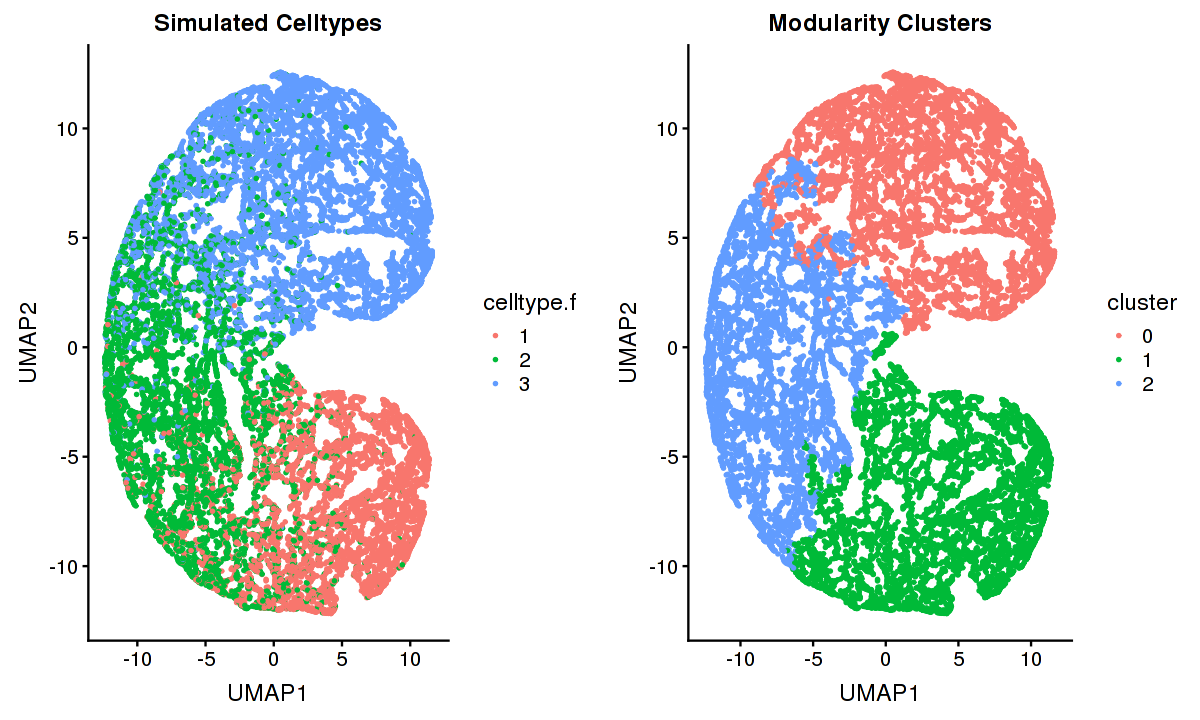

In [356]:
options(repr.plot.height = 6, repr.plot.width = 10)
sim2.plot <- testSim$V %>% data.frame() %>% cbind(testSim$meta, umap_cols) %<>% mutate(cluster = factor(ids_ref[[1]]),
                                                                                       celltype.f = factor(celltype)) %>% dplyr::sample_frac(1L)
p1 <- sim2.plot %>%
    ggplot(aes(x = UMAP1, y = UMAP2)) + 
    geom_point(aes(color = celltype.f), size = 0.5) +
    ggtitle("Simulated Celltypes")
p2 <- sim2.plot %>%
    ggplot(aes(x = UMAP1, y = UMAP2)) + 
    geom_point(aes(color = cluster), size = 0.5) +
    ggtitle("Modularity Clusters")
multiplot(p1, p2, cols = 2)

Warning message in check_pal_n(n, max_n):
“This palette can handle a maximum of 20 values.You have supplied 24.”Warning message:
“Removed 4000 rows containing missing values (geom_point).”

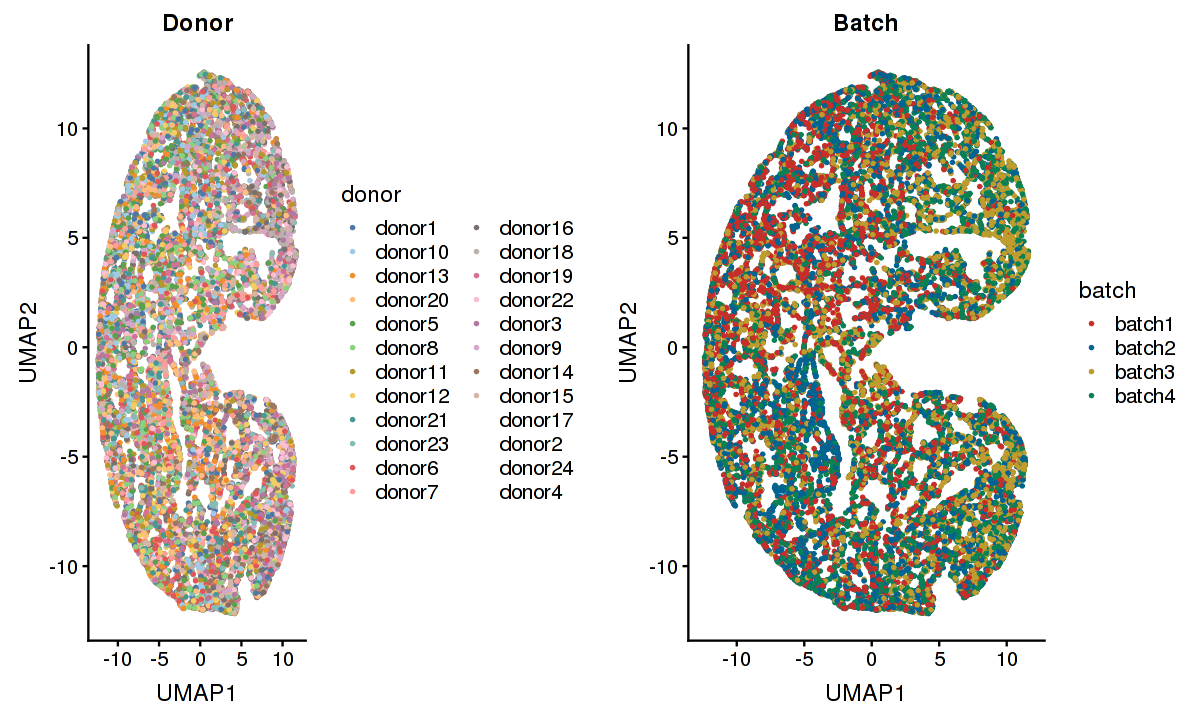

In [361]:
p1 <- sim2.plot %>%
    ggplot(aes(x = UMAP1, y = UMAP2)) + 
    geom_point(aes(color = donor), size = 0.5) +
    ggtitle("Donor")
p2 <- sim2.plot %>%
    ggplot(aes(x = UMAP1, y = UMAP2)) + 
    geom_point(aes(color = batch), size = 0.5) +
    scale_color_wsj() +
    ggtitle("Batch")
multiplot(p1, p2, cols = 2)

## Batch at 200% of centroid variance, donor at 10%

Now try with increased batch SD

In [380]:
ncells <- 1000
ngenes <- 500
nbatches <- 4
ncases <- 12
nctrls <- 12
case_freq <- c(0.2, 0.3, 0.5)
ctrl_freq <- rep(1/3, 3)
batch_sd <- 2
donor_sd <- 0.1

In [381]:
testSim <- simulateDataset(centroid_list = centroid_list, 
                            centroid_variance = centroid_variance, 
                            ngenes = ngenes,
                            ncells = ncells, 
                            nbatches = nbatches, 
                            ncases = ncases, 
                            nctrls = nctrls,
                            case_cluster_frequency = case_freq,
                            ctrl_cluster_frequency = ctrl_freq, 
                            batch_sd = batch_sd, 
                            donor_sd = donor_sd) 

Simulated 3 cases and 3 controls in batch 1
Simulated 3 cases and 3 controls in batch 2
Simulated 3 cases and 3 controls in batch 3
Simulated 3 cases and 3 controls in batch 4
Finished simulating a 24000 cell by 500 gene dataset consisting of 12 cases and 12 controls


In [382]:
# PCA representation of data
testSim$pca <- irlba::prcomp_irlba(testSim$exprs, 20)$x
message(paste0("PCA completed at ", Sys.time()))

PCA completed at 2019-08-21 12:45:28


In [383]:
snn_ref <- BuildSNNSeurat(testSim$pca, nn.eps = 0)
res_use <- 0.05
ids_ref <- Seurat:::RunModularityClustering(SNN = snn_ref, modularity = 1, resolution = res_use, algorithm = 1, n.start = 20, 
                                            n.iter = 20, random.seed = 100, print.output = FALSE, temp.file.location = NULL, edge.file.name = NULL)
ids_ref %<>% data.frame()    
message(paste0("SNN modularity clustering completed at ", Sys.time()))
table(ids_ref)

SNN modularity clustering completed at 2019-08-21 12:45:34


ids_ref
   0    1    2 
9735 7718 6547 

In [384]:
table(ids_ref[[1]], testSim$meta$celltype)

   
       1    2    3
  0 6157 3519   59
  1  149 1987 5582
  2   67 2136 4344

In [385]:
umap_res <- umap(testSim$pca)
umap_cols <- umap_res$layout %>% data.frame
colnames(umap_cols) <- c("UMAP1", "UMAP2")
message(paste0("UMAP completed at ", Sys.time()))

UMAP completed at 2019-08-21 12:49:11


In [386]:
dim(umap_cols)

[1] 24000     2

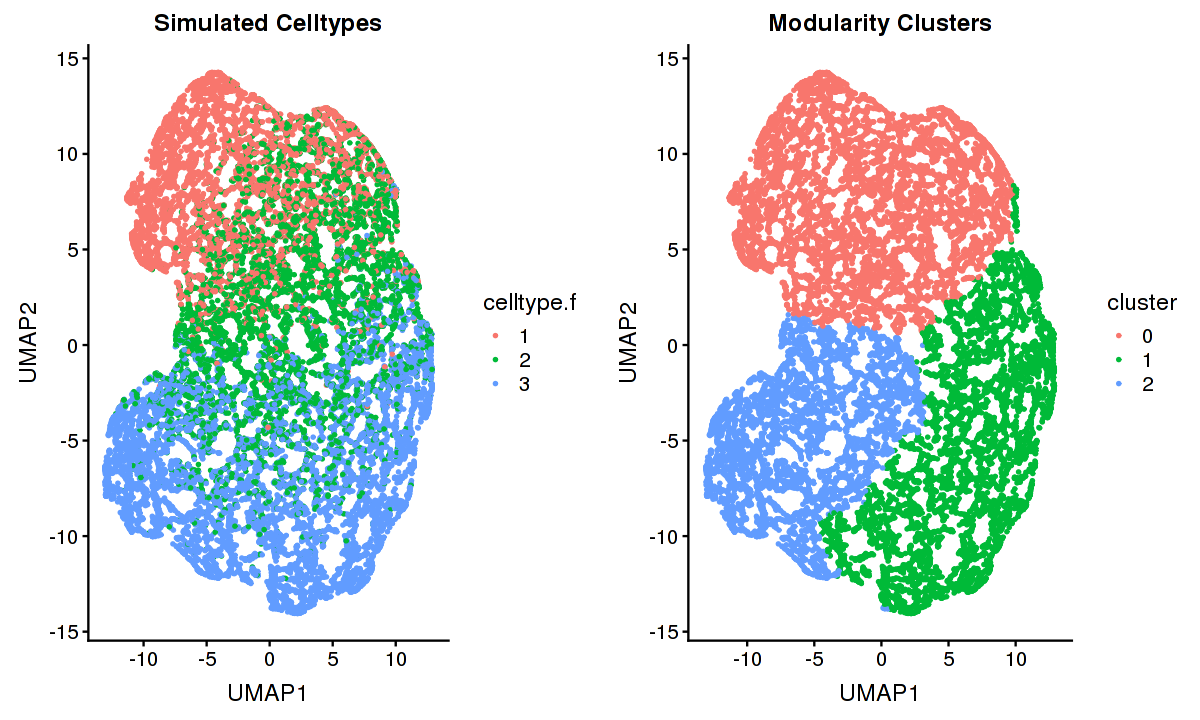

In [387]:
options(repr.plot.height = 6, repr.plot.width = 10)
sim1.plot <- testSim$pca %>% data.frame() %>% cbind(testSim$meta, umap_cols) %<>% mutate(cluster = factor(ids_ref[[1]]),
                                                                                       celltype.f = factor(celltype)) %>% dplyr::sample_frac(1L)
p1 <- sim1.plot %>%
    ggplot(aes(x = UMAP1, y = UMAP2)) + 
    geom_point(aes(color = celltype.f), size = 0.5) +
    ggtitle("Simulated Celltypes")
p2 <- sim1.plot %>%
    ggplot(aes(x = UMAP1, y = UMAP2)) + 
    geom_point(aes(color = cluster), size = 0.5) +
    ggtitle("Modularity Clusters")
multiplot(p1, p2, cols = 2)

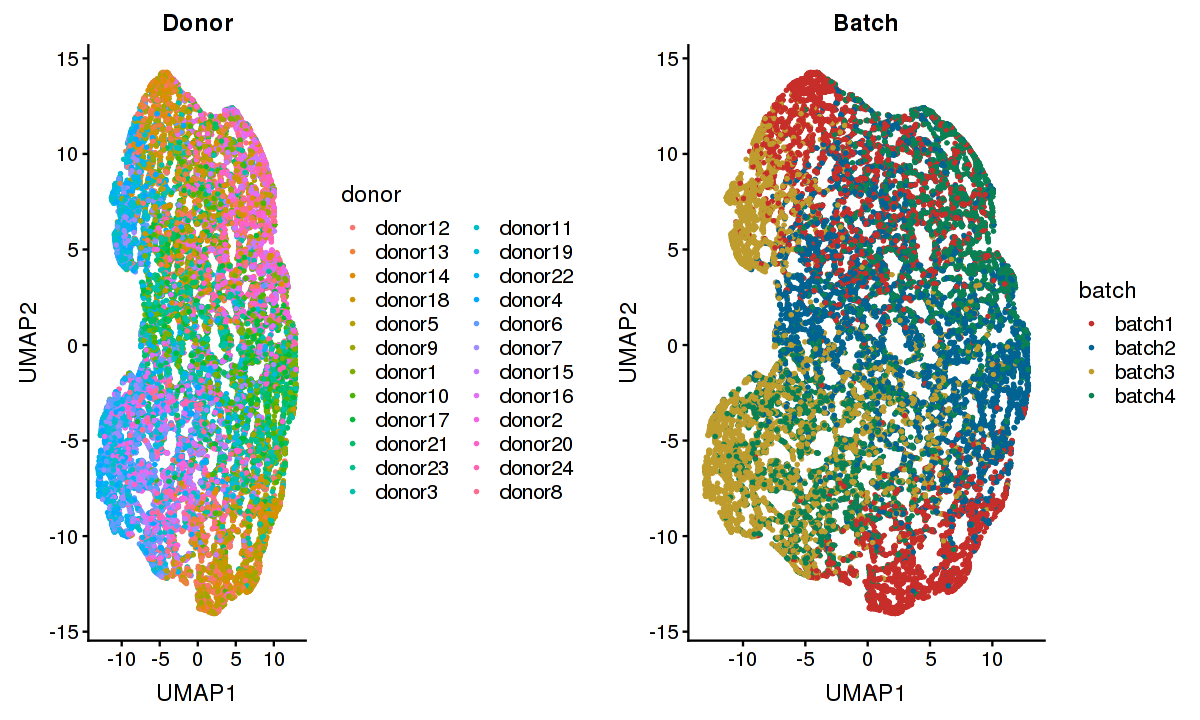

In [388]:
p1 <- sim1.plot %>%
    ggplot(aes(x = UMAP1, y = UMAP2)) + 
    geom_point(aes(color = donor), size = 0.5) +
    ggtitle("Donor")
p2 <- sim1.plot %>%
    ggplot(aes(x = UMAP1, y = UMAP2)) + 
    geom_point(aes(color = batch), size = 0.5) +
    scale_color_wsj() +
    ggtitle("Batch")
multiplot(p1, p2, cols = 2)

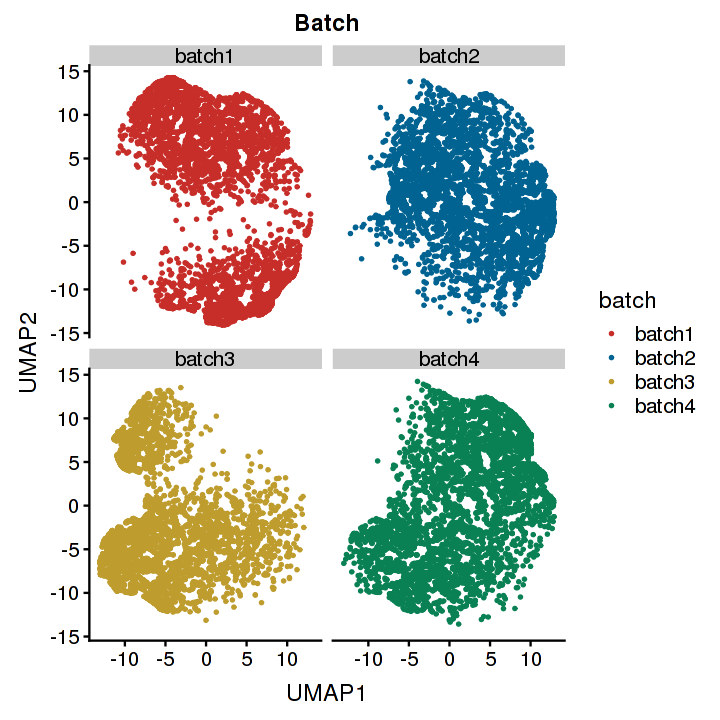

In [390]:
options(repr.plot.height = 6, repr.plot.width = 6) 
sim1.plot %>%
    ggplot(aes(x = UMAP1, y = UMAP2)) + 
    geom_point(aes(color = batch), size = 0.5) +
    scale_color_wsj() +
    ggtitle("Batch") + 
    facet_wrap(~ batch)

In [397]:
levels(sim1.plot$cluster) <- levels(sim1.plot$celltype.f)

In [402]:
table(modularity = sim1.plot$cluster, reference = sim1.plot$celltype.f)

          reference
modularity    1    2    3
         1 6157 3519   59
         2  149 1987 5582
         3   67 2136 4344

## Batch at 10%, donor at 200%

In [403]:
ncells <- 1000
ngenes <- 500
nbatches <- 4
ncases <- 12
nctrls <- 12
case_freq <- c(0.2, 0.3, 0.5)
ctrl_freq <- rep(1/3, 3)
batch_sd <- 0.1
donor_sd <- 2

In [404]:
testSim3 <- simulateDataset(centroid_list = centroid_list, 
                            centroid_variance = centroid_variance, 
                            ngenes = ngenes,
                            ncells = ncells, 
                            nbatches = nbatches, 
                            ncases = ncases, 
                            nctrls = nctrls,
                            case_cluster_frequency = case_freq,
                            ctrl_cluster_frequency = ctrl_freq, 
                            batch_sd = batch_sd, 
                            donor_sd = donor_sd) 

Simulated 3 cases and 3 controls in batch 1
Simulated 3 cases and 3 controls in batch 2
Simulated 3 cases and 3 controls in batch 3
Simulated 3 cases and 3 controls in batch 4
Finished simulating a 24000 cell by 500 gene dataset consisting of 12 cases and 12 controls


In [405]:
# PCA representation of data
testSim3$pca <- irlba::prcomp_irlba(testSim3$exprs, 20)$x
message(paste0("PCA completed at ", Sys.time()))

PCA completed at 2019-08-21 13:04:31


In [406]:
snn_ref <- BuildSNNSeurat(testSim$pca, nn.eps = 0)
res_use <- 0.05
ids_ref <- Seurat:::RunModularityClustering(SNN = snn_ref, modularity = 1, resolution = res_use, algorithm = 1, n.start = 20, 
                                            n.iter = 20, random.seed = 100, print.output = FALSE, temp.file.location = NULL, edge.file.name = NULL)
ids_ref %<>% data.frame()    
message(paste0("SNN modularity clustering completed at ", Sys.time()))
table(ids_ref)

SNN modularity clustering completed at 2019-08-21 13:04:35


ids_ref
   0    1    2 
9735 7718 6547 

In [407]:
table(ids_ref[[1]], testSim3$meta$celltype)

   
       1    2    3
  0 2704 3132 3899
  1 2017 2446 3255
  2 1717 2003 2827

In [408]:
umap_res <- umap(testSim3$pca)
umap_cols <- umap_res$layout %>% data.frame
colnames(umap_cols) <- c("UMAP1", "UMAP2")
message(paste0("UMAP completed at ", Sys.time()))

UMAP completed at 2019-08-21 13:07:40


In [409]:
dim(umap_cols)

[1] 24000     2

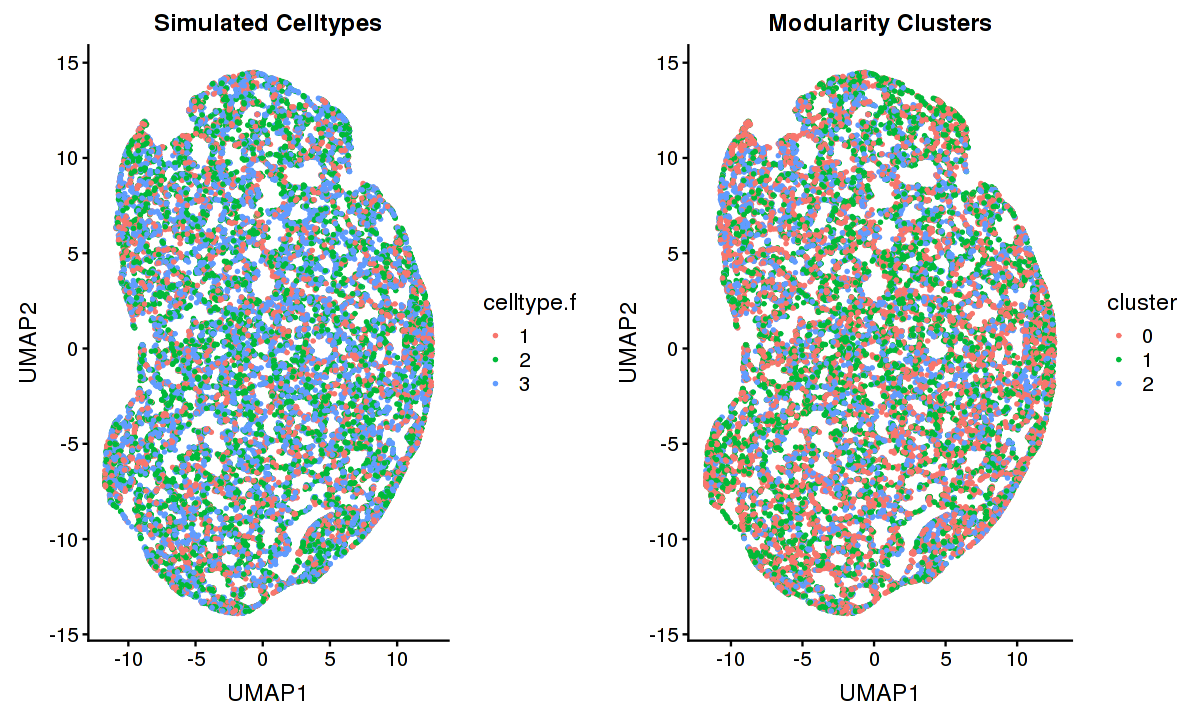

In [410]:
options(repr.plot.height = 6, repr.plot.width = 10)
sim3.plot <- testSim3$pca %>% data.frame() %>% cbind(testSim$meta, umap_cols) %<>% mutate(cluster = factor(ids_ref[[1]]),
                                                                                       celltype.f = factor(celltype)) %>% dplyr::sample_frac(1L)
p1 <- sim3.plot %>%
    ggplot(aes(x = UMAP1, y = UMAP2)) + 
    geom_point(aes(color = celltype.f), size = 0.5) +
    ggtitle("Simulated Celltypes")
p2 <- sim3.plot %>%
    ggplot(aes(x = UMAP1, y = UMAP2)) + 
    geom_point(aes(color = cluster), size = 0.5) +
    ggtitle("Modularity Clusters")
multiplot(p1, p2, cols = 2)

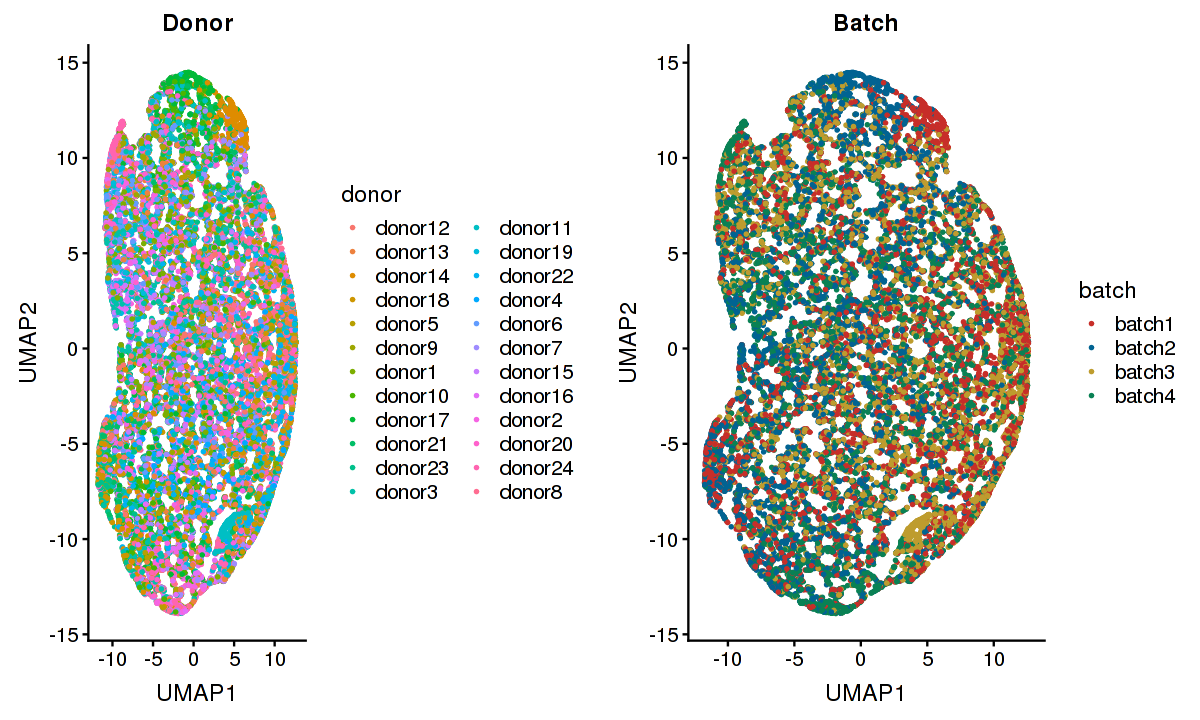

In [411]:
p1 <- sim3.plot %>%
    ggplot(aes(x = UMAP1, y = UMAP2)) + 
    geom_point(aes(color = donor), size = 0.5) +
    ggtitle("Donor")
p2 <- sim3.plot %>%
    ggplot(aes(x = UMAP1, y = UMAP2)) + 
    geom_point(aes(color = batch), size = 0.5) +
    scale_color_wsj() +
    ggtitle("Batch")
multiplot(p1, p2, cols = 2)

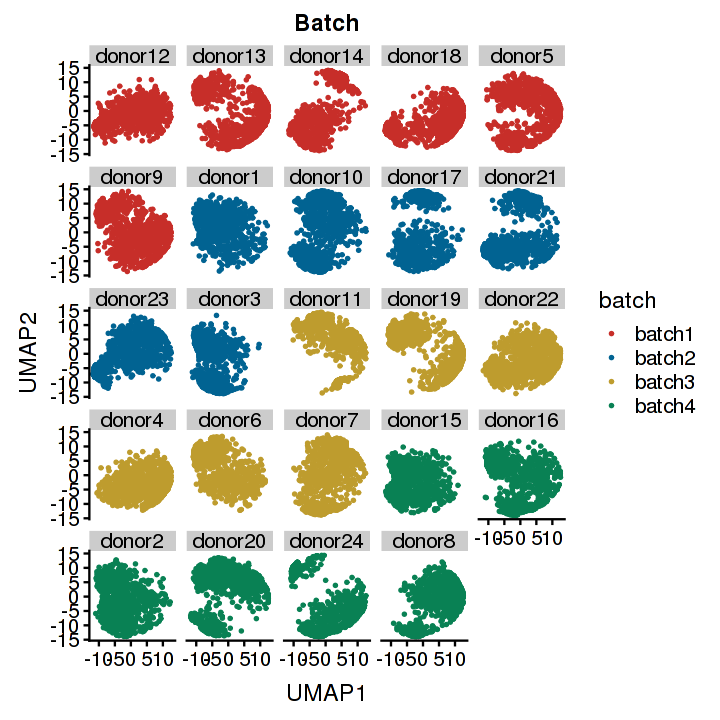

In [413]:
options(repr.plot.height = 6, repr.plot.width = 6) 
sim3.plot %>%
    ggplot(aes(x = UMAP1, y = UMAP2)) + 
    geom_point(aes(color = batch), size = 0.5) +
    scale_color_wsj() +
    ggtitle("Batch") + 
    facet_wrap(~ donor)